In [18]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier 
from sklearn import tree
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import export_graphviz
from sklearn.model_selection import cross_validate

from pyspark.sql import SparkSession

import warnings
warnings.filterwarnings('ignore')


In [19]:
df = pd.read_csv('./data/diabetes_prediction.csv')

df

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0
...,...,...,...,...,...,...,...,...,...
99995,Female,80.0,0,0,No Info,27.32,6.2,90,0
99996,Female,2.0,0,0,No Info,17.37,6.5,100,0
99997,Male,66.0,0,0,former,27.83,5.7,155,0
99998,Female,24.0,0,0,never,35.42,4.0,100,0


In [20]:
colmn = df.columns
print(colmn)

Index(['gender', 'age', 'hypertension', 'heart_disease', 'smoking_history',
       'bmi', 'HbA1c_level', 'blood_glucose_level', 'diabetes'],
      dtype='object')


In [21]:
# Let's Encod data
encoder = LabelEncoder()
colmn = df.columns
for index, name in enumerate(colmn):
    df[name] = encoder.fit_transform(df[name].values)

df.corr()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
gender,1.000000,-0.031903,0.014203,0.077696,-0.077919,-0.022141,0.019957,0.013391,0.037411
age,-0.031903,1.000000,0.248903,0.230673,0.233626,0.352825,0.099908,0.086596,0.255796
hypertension,0.014203,0.248903,1.000000,0.121262,0.093177,0.149550,0.081025,0.066354,0.197823
heart_disease,0.077696,0.230673,0.121262,1.000000,0.027598,0.062829,0.067447,0.053975,0.171727
smoking_history,-0.077919,0.233626,0.093177,0.027598,1.000000,0.182755,0.037973,0.032706,0.094290
bmi,-0.022141,0.352825,0.149550,0.062829,0.182755,1.000000,0.082446,0.072347,0.215203
HbA1c_level,0.019957,0.099908,0.081025,0.067447,0.037973,0.082446,1.000000,0.130420,0.399276
blood_glucose_level,0.013391,0.086596,0.066354,0.053975,0.032706,0.072347,0.130420,1.000000,0.326084
diabetes,0.037411,0.255796,0.197823,0.171727,0.094290,0.215203,0.399276,0.326084,1.000000


<Axes: >

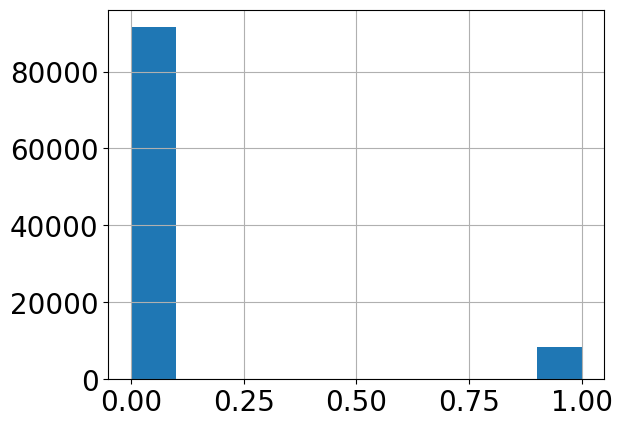

In [22]:
df['diabetes'].hist()

# Disbalance in classes (

In [23]:
# there are literli function plot_tree to visualize that

X = df.drop(columns='diabetes')
y = pd.DataFrame(df['diabetes'])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

# Fit the classifier with default hyper-parameters
clf = DecisionTreeClassifier(max_depth=8)
model = clf.fit(X, y)

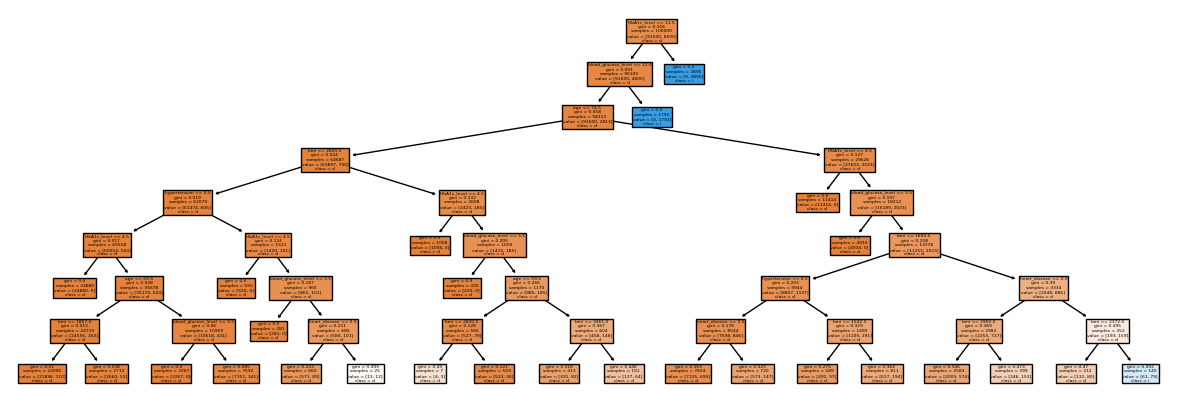

In [24]:
fig = plt.figure(figsize=(15, 5))
_ = tree.plot_tree(clf, 
                   feature_names=X.columns,  
                   class_names='diabetes',
                   filled=True)

Confusion matrix, without normalization
[[30200    16]
 [  907  1877]]


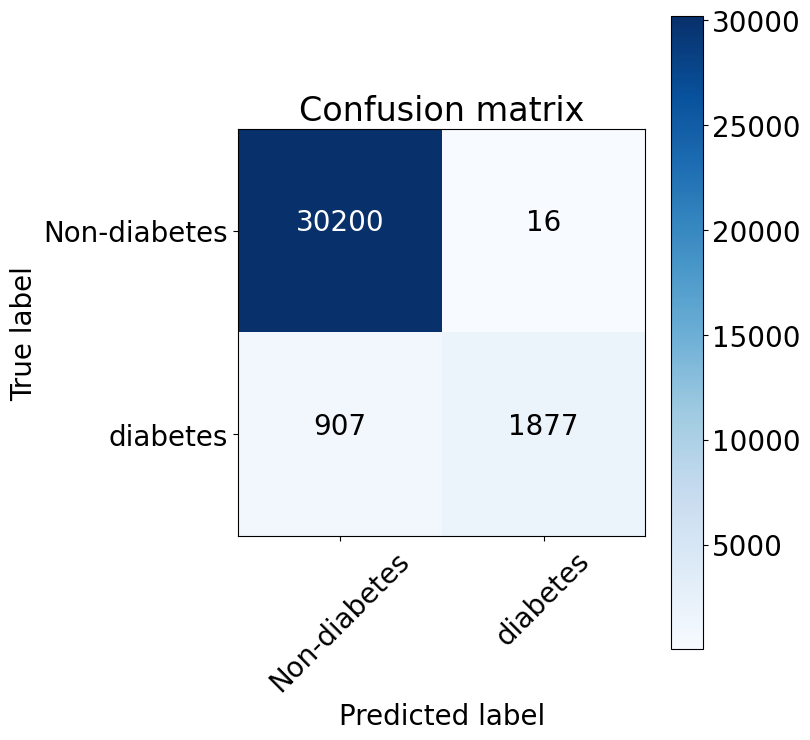

In [25]:
from sklearn.metrics import confusion_matrix
import itertools

pred_rt = model.predict(X_test)

accuracy_score(y_test, pred_rt)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

font = {'size' : 20}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, model.predict(X_test))
plt.figure(figsize=(8, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-diabetes', 'diabetes'],
                      title='Confusion matrix')
plt.show()

In [26]:
report = classification_report(y_test, model.predict(X_test), target_names=['Non-diabetes', 'diabetes'])
print(report)

              precision    recall  f1-score   support

Non-diabetes       0.97      1.00      0.98     30216
    diabetes       0.99      0.67      0.80      2784

    accuracy                           0.97     33000
   macro avg       0.98      0.84      0.89     33000
weighted avg       0.97      0.97      0.97     33000



<h4>Gradient boost</h4>

In [27]:
params = {'n_estimators':200,
          'max_depth':12,
          'criterion':'squared_error',
          'learning_rate':0.03,
          'min_samples_leaf':16,
          'min_samples_split':16
          }

gbr = GradientBoostingClassifier(**params)
gbr.fit(X_train, y_train)

pred_grd = gbr.predict(X_test)

Confusion matrix, without normalization
[[30134    82]
 [  862  1922]]


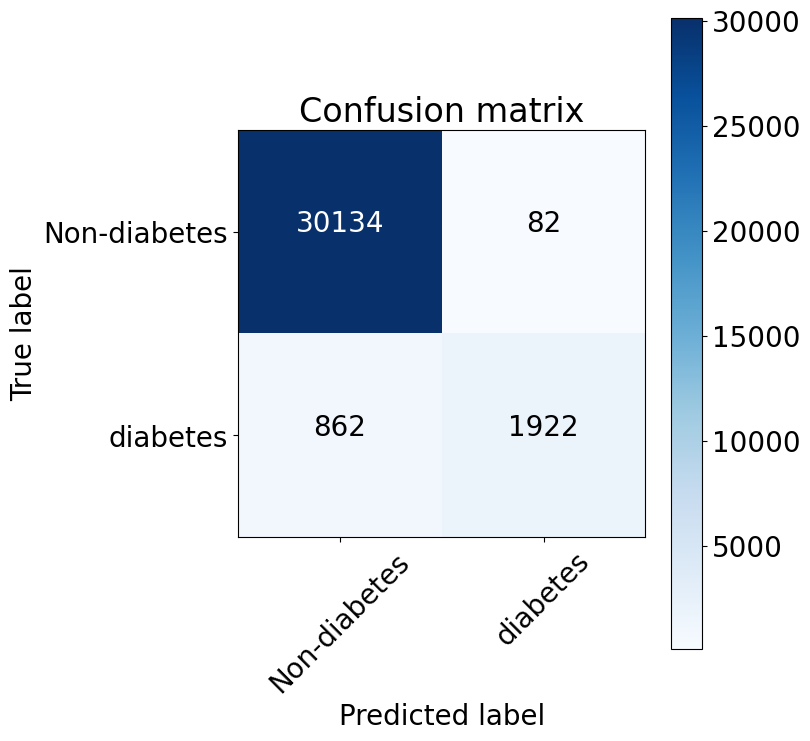

In [28]:
font = {'size' : 20}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, gbr.predict(X_test))
plt.figure(figsize=(8, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-diabetes', 'diabetes'],
                      title='Confusion matrix')
plt.show()

In [29]:
report = classification_report(y_test, gbr.predict(X_test), target_names=['Non-diabetes', 'diabetes'])
print(report)

              precision    recall  f1-score   support

Non-diabetes       0.97      1.00      0.98     30216
    diabetes       0.96      0.69      0.80      2784

    accuracy                           0.97     33000
   macro avg       0.97      0.84      0.89     33000
weighted avg       0.97      0.97      0.97     33000



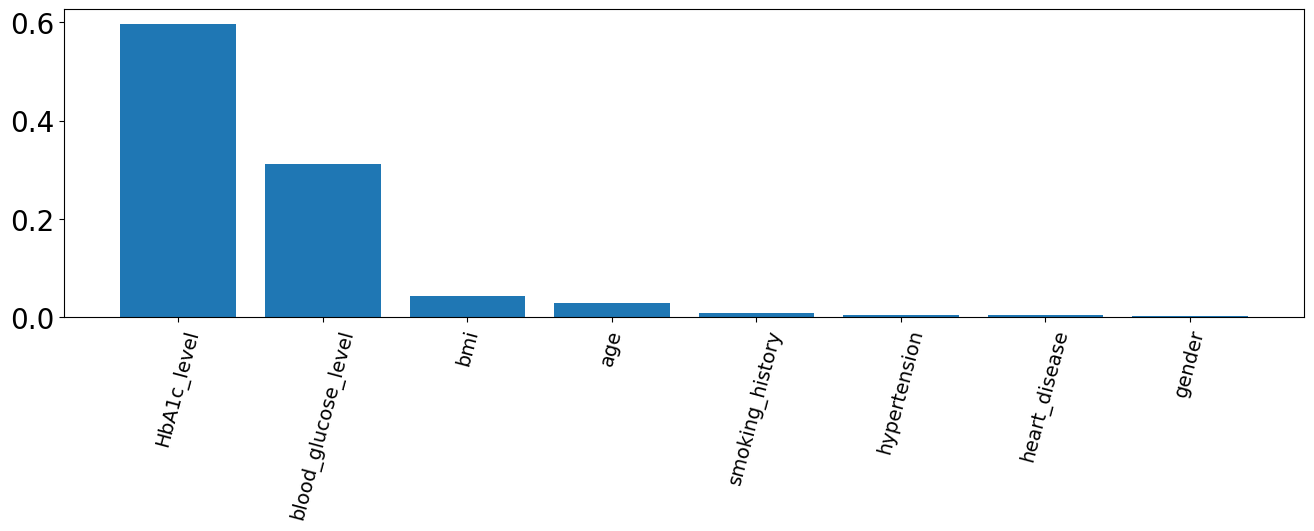

In [30]:
feature_importance = gbr.feature_importances_
feature_importance_dict = dict(zip(X_test.columns, feature_importance))
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

variables, importance = zip(*sorted_feature_importance)
fig = plt.figure(figsize=(16, 4))
plt.bar(variables, importance)
plt.xticks(fontsize=14,rotation=75)
plt.show()

<h3>Dependense in model</h3>

In [53]:
leath_nodes = np.array([i for i in range(2, 6000, 400)], dtype=np.int16)
train_score = np.array([0 for i in range(len(leath_nodes))], dtype=np.float32)
valid_score = np.array([0 for i in range(len(leath_nodes))], dtype=np.float32)

X_tr, X_ts, y_tr, y_ts = train_test_split(X, y, test_size=0.1, random_state=1)

#cv = StratifiedKFold(n_splits=5) # For validation

for index, leath in enumerate(leath_nodes):
    # I need to calculate score with most
    #trn_mn = []
    #vld_mn = []

    local_model = GradientBoostingClassifier(
            max_depth=5,
            criterion = 'squared_error',
            max_leaf_nodes = leath
        )
    cv_results = cross_validate(local_model, X_tr, y_tr, cv=3, return_estimator=True,
                                scoring='f1'
                                )
    print(f'{index + 1}. for {leath} of leaths cv_reesults is {cv_results["test_score"]} ', end='\n')
    valid_score[index] =  np.min(cv_results['test_score'])
    local_model.fit(X_tr, y_tr)
    train_score[index] = f1_score(y_tr, local_model.predict(X_tr))
print(valid_score)

1. for 2 of leaths cv_reesults is [0.80122468 0.79754311 0.80244591] 
2. for 402 of leaths cv_reesults is [0.807987   0.79981378 0.80956804] 
3. for 802 of leaths cv_reesults is [0.807987   0.79981378 0.80956804] 
4. for 1202 of leaths cv_reesults is [0.807987   0.79981378 0.80956804] 
5. for 1602 of leaths cv_reesults is [0.807987   0.79981378 0.80956804] 
6. for 2002 of leaths cv_reesults is [0.807987   0.79981378 0.80956804] 
7. for 2402 of leaths cv_reesults is [0.807987   0.79981378 0.80956804] 
8. for 2802 of leaths cv_reesults is [0.807987   0.79981378 0.80956804] 
9. for 3202 of leaths cv_reesults is [0.807987   0.79981378 0.80956804] 
10. for 3602 of leaths cv_reesults is [0.807987   0.79981378 0.80956804] 
11. for 4002 of leaths cv_reesults is [0.807987   0.79981378 0.80956804] 
12. for 4402 of leaths cv_reesults is [0.807987   0.79981378 0.80956804] 
13. for 4802 of leaths cv_reesults is [0.807987   0.79981378 0.80956804] 
14. for 5202 of leaths cv_reesults is [0.807987   0.

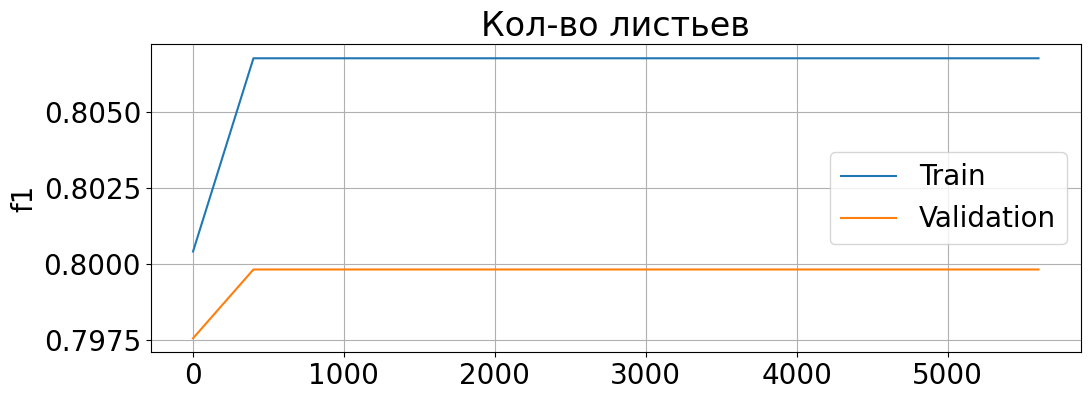

In [55]:
plt.figure(figsize=(12, 4))
plt.plot(leath_nodes, train_score, label='Train')
plt.plot(leath_nodes, valid_score, label='Validation')
plt.xlabel('')
plt.ylabel('f1')
plt.title('Кол-во листьев')
plt.grid(True)
plt.legend()
plt.show()

<h3>Dependense but with deep of model</h3>

In [1]:
deep_of_md = np.array([i for i in range(2, 20, 4)], dtype=np.int16)
train_score = np.array([[]])
valid_score = np.array([[]])
n_estimators_values = np.arange(1, 150, 5)
X_tr, X_ts, y_tr, y_ts = train_test_split(X, y, test_size=0.1, random_state=1)

for arr_int, deep_gb in enumerate(deep_of_md):

    train_scores_depth = []
    valid_scores_depth = []

    for num_of_est in n_estimators_values:
        local_model = GradientBoostingClassifier(
            max_depth=deep_gb,
            criterion = 'squared_error',
            n_estimators = num_of_est
        )
        cv_results = cross_validate(local_model, X_tr, y_tr, cv=3, return_estimator=True,
                                    scoring='f1'
                                    )
        valid_scores_depth.append(np.min(cv_results['test_score']))
        local_model.fit(X_tr, y_tr)
        train_scores_depth.append(f1_score(y_tr, local_model.predict(X_tr)))
    
    train_score.append(train_scores_depth)
    valid_score.append(valid_scores_depth)


NameError: name 'np' is not defined